In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

basics see multibody boltzmann

# Ideal Gas Law

We essentially want to show that $$PV = Nk_B T$$
where $P$ is pressure, $V=L^3$ is the volume of a box, $N$ is the number of particles, and $k_B$ is Boltzmann's constant. Noting that $E=3/2k_BT$ (kinetic theory of gases) we can write $1/2mv_{average}^2=3/2k_bT$ or that $$T=\frac{m}{3k_B}v_{average}^2$$

Since no energy is lost, $v_{average}$ will remain the same throughout the simulation (not we assume that all particles have the same mass $m$ here). We can rewrite the right hand side (RHS) of the ideal gas law as $$RHS = \frac{Nm}{3}v_{average}^2$$
In our billiard ball simulation, the RHS can be computed based on the initial state. We choose the number of particles $N$ and initial velocities $v$ and this can be computed. The purpose of the simulation will be to show that the $RHS$ is equal to $PV$ (which is computed based on balls hitting walls).

The pressure is given by $P = F/(6L^2)$ where $F$ is the force and $L$ is the side length of the box. We just need to compute the imparted force. Noting that $F = \Delta p / \Delta t$, we can compute the force as follows:",

* We track particles that hit the walls of the box and compute the change of momentum $\Delta p_i$ given to the box at each time step.
* The force is then $F = \sum_i |\Delta p_i| / t$ where $t$ is the length of time of the simulation.
* Note that $p_i = mv_i$

We can substitute this into $P$ and set $V=L^3$ to get
$$LHS = \frac{mL \sum |\Delta v_i|}{6 \Delta t}$$
So if we compute $RHS$ at the beginning of the simulation, run the simulation, and show that $LHS$ is equal, then we have effectively provided Monte Carlo based evidence for the ideal gas law. Since both are proportional to mass, we'll neglect $m$ and simply show that  $LHS/m = RHS/m$

In [14]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    dz = torch.diff(torch.stack([r[2][ids_pairs[:,0]], r[2][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2 + dz**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, L, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, *r.shape)).to(device)
    vs = torch.zeros((ts, *v.shape)).to(device)
    
    rs[0] = r
    vs[0] = v
    dv = torch.zeros(ts).to(device)
    
    for i in range(1, ts):
        ic = id_pairs[get_deltad2_pairs(r, id_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>L] = -torch.abs(v[0,r[0]>L])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[0]>L]))
        
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[0]<0]))
        
        v[1,r[1]>L] = -torch.abs(v[1,r[1]>L])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[1]>L]))
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        dv[i] += 2*torch.sum(torch.abs(v[1,r[1]<0]))
        
        v[2,r[2]>L] = -torch.abs(v[2,r[2]>L])
        dv[i] += 2*torch.sum(torch.abs(v[2,r[2]>L]))
        v[2,r[2]<0] = torch.abs(v[2,r[2]<0])
        dv[i] += 2*torch.sum(torch.abs(v[2,r[2]<0]))
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs, dv

In [28]:
N = 3000
dt = 8e-6
t_steps = 2000
t = np.arange(t_steps)*dt
v0 = 500
L = 1
r = torch.rand((3,N)).to(device)
ixr = r[0] >0.5
ixl = r[0] <=0.5
ids = torch.arange(N)
ids_pairs = torch.combinations(ids, 2).to(device)
v = torch.zeros((3,N)).to(device)
v[0][ixr] = -v0
v[0][ixl] = v0
radius = 0.005
rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)

First, lets take a look at the change in velocity $|\Delta v_i|$ induced by theparticles hitting the walls:

Text(0, 0.5, '$\\Delta v_i$ [m/s]')

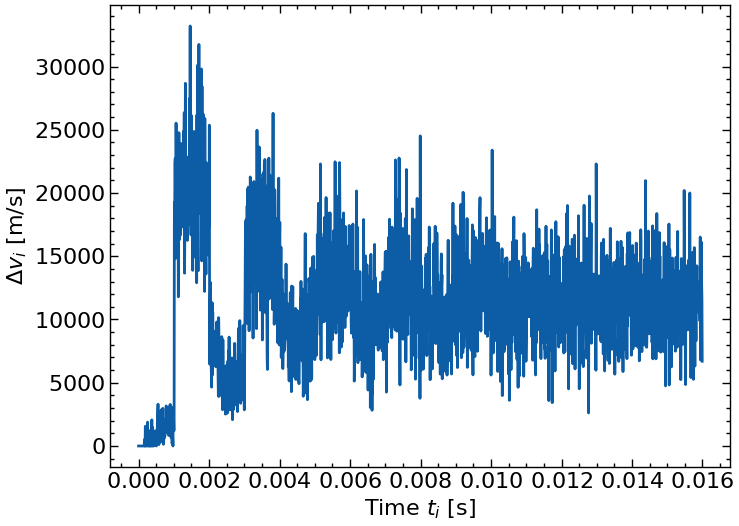

In [29]:
plt.plot(t, dv.cpu())
plt.xlabel(r'Time $t_i$ [s]')
plt.ylabel(r'$\Delta v_i$ [m/s]')

Since the particles are initially moving either left or reight at 500m/s, pressure only gets exerted on the wall when they all reach the wall. Over time, the gas particles get distributed according to the Boltzmann distribution and the pressure becomes more constant.

So we'll cumpute LHS and RHS using only the last 1000 points of the simulation(when the gas has reached its Boltzm,ann diustribution state)

In [30]:
n_points = 1000
LHS = torch.sum(dv[-n_points:]) / (6 * L**2 * dt * n_points)
RHS = N / 3 * v0**2

print(LHS.item(), RHS)

237463584.0 250000000.0


These numbers, being very close, provide evidence for the ideal gas law the pressure is $P \propto T$. We can do multiple simulations and plot the following equation. Noting LHS is equal to $PV$ and the RHS is equal to $Nk_BT$ we can change the values of $v_0$ and show a linear realationship:

In [31]:
def run_simulation_P_prop_T(N, v0, L, radius=0.005, n_points=1000, t_steps=4000):
    dt = 8e-6
    r = torch.rand((3,N)).to(device)
    ixr = r[0] >0.5
    ixl = r[0] <=0.5
    ids = torch.arange(N)
    ids_pairs = torch.combinations(ids, 2).to(device)
    v = torch.zeros((3,N)).to(device)
    v[0][ixr] = -v0
    v[0][ixl] = v0
    radius = 0.005
    rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)
    
    LHS = torch.sum(dv[-n_points:]) / (6 * L**2 * dt * n_points)
    RHS = N / 3 * v0**2
    return LHS.item(), RHS

In [33]:
v0s = [300, 500, 700, 900]
LHSs = []
RHSs = []

for v0 in v0s:
    LHS, RHS = run_simulation_P_prop_T(N=3000, v0=v0, L=1)
    LHSs.append(LHS)
    RHSs.append(RHS)

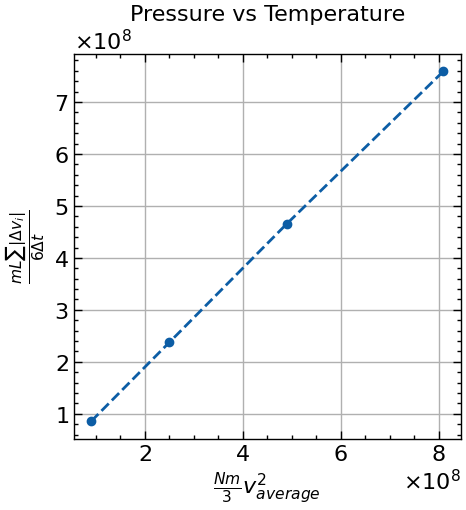

In [34]:
plt.figure(figsize=(5,5))
plt.plot(RHSs, LHSs, 'o--')
plt.title('Pressure vs Temperature')
plt.xlabel(r'$\frac{Nm}{3}v_{average}^2$')
plt.ylabel(r'$\frac{mL \sum |\Delta v_i|}{6 \Delta t}$')
plt.grid()
plt.show()


In [ ]:
def run_simulation_P_prop_T(N, v0, L, radius=0.005, n_points=1000, t_steps=4000):
    dt = 8e-6
    r = torch.rand((3,N)).to(device)
    ixr = r[0] >0.5
    ixl = r[0] <=0.5
    ids = torch.arange(N)
    ids_pairs = torch.combinations(ids, 2).to(device)
    v = torch.zeros((3,N)).to(device)
    v[0][ixr] = -v0
    v[0][ixl] = v0
    radius = 0.005
    rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)
    
    LHS = torch.sum(dv[-n_points:]) / (6 * L**2 * dt * n_points)
    RHS = N / 3 * v0**2
    return LHS.item(), RHS